In [1]:
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision.transforms import v2
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt


#### Dataset downloading and normalization using standart for CIFAR-10 mean and std values

In [2]:
transform = v2.Compose([v2.ToTensor(),
     v2.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

/home/vadimpp/.local/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [3]:
len(trainset)

50000

#### Let's examine the data we have to determine its specifics. 

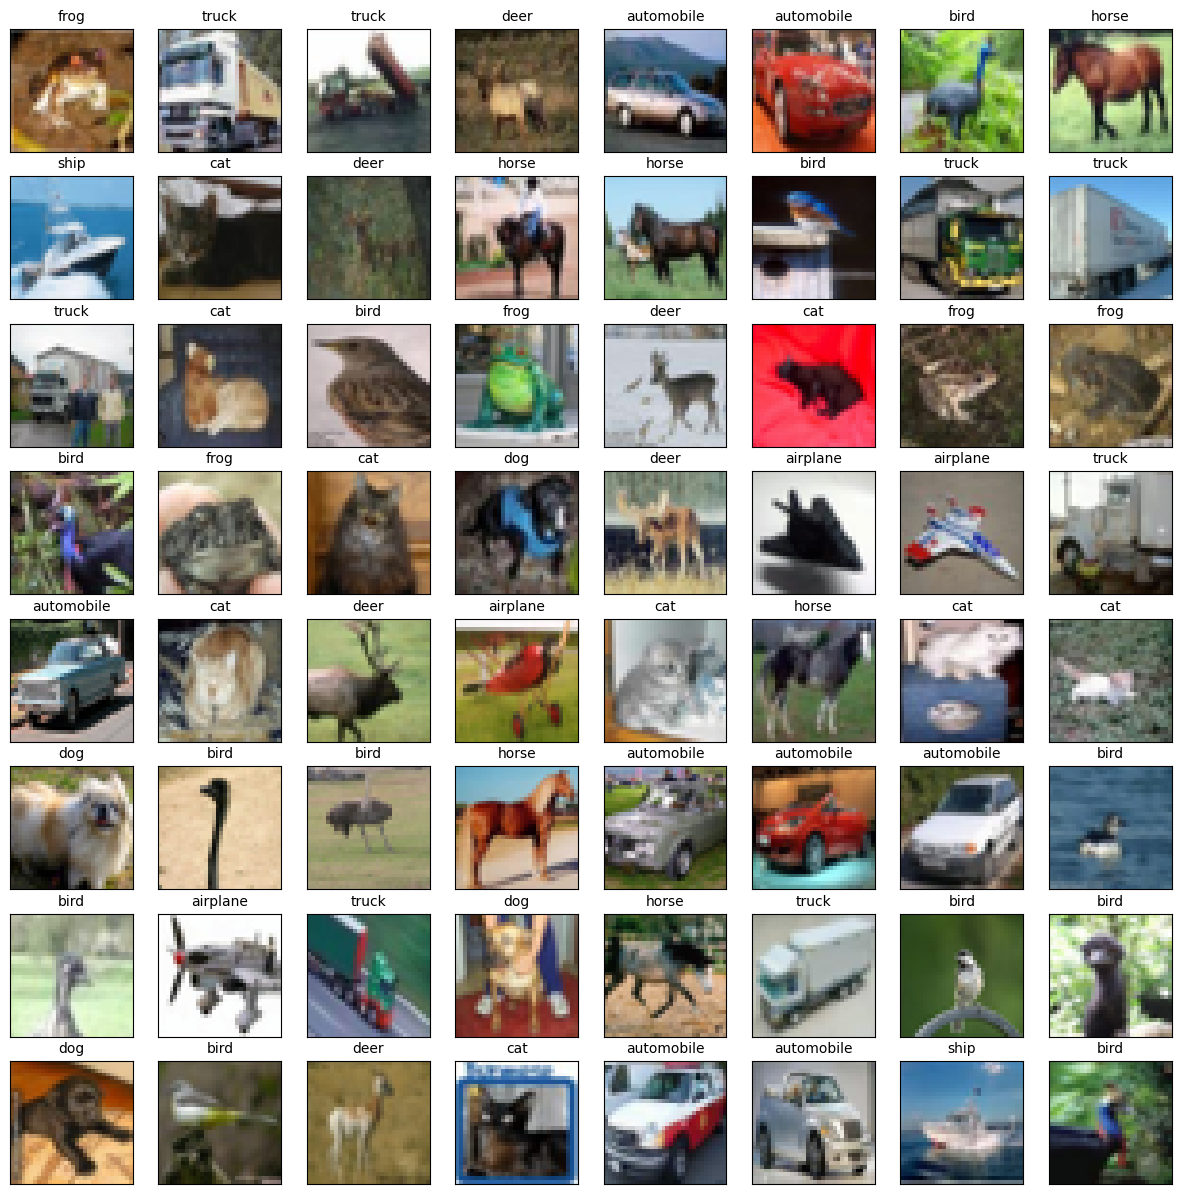

In [4]:
id_to_cl = {idx:cl for cl,idx in trainset.class_to_idx.items()}

# Mean and std of CIFAR values
mean = [0.4914, 0.4822, 0.4465]
std = [0.247, 0.243, 0.261]

plt.figure(figsize = (15,15))

for i in range(64):
    img, label = trainset[i]    
    img = img.permute(1, 2, 0).numpy()
    img = img * std + mean              
    img = img.clip(0, 1)                

    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(id_to_cl[label],fontsize = 10)

    plt.imshow(img)
plt.show()


#### Let's define the dataset class that will contain both the original data and the data that has undergone augmentation through synthetic transformations.

In [5]:
class augmCIFAR(Dataset):
    def __init__(self, transform=None, synt_transform = None):
        self.transform = transform
        self.synt_transform = synt_transform    # Transformations for Data Augmentation  
        self.initial_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=self.transform)
        self.synthetic_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=self.synt_transform) if synt_transform else []

    def __len__(self):
        return len(self.initial_dataset) + len(self.synthetic_data) 

    def __getitem__(self,idx):
        img, label = 0,0
        if idx<len(self.initial_dataset):
            img, label = self.initial_dataset[idx]
        else:
            img, label = self.synthetic_data[len(self.initial_dataset) - idx]
        return img, label     
        

Through testing, the most effective combination of transformations for creating a synthetic image set is the following combination: a set of rotations, reflections, cropping, etc.

In [6]:
synt_transforms = v2.Compose([
    v2.RandomRotation(15),
    v2.RandomCrop(32),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.ToTensor(),                
    v2.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])  
])
transform = v2.Compose([v2.ToTensor(),
     v2.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])
    

In [7]:
train_ds = augmCIFAR(transform, synt_transforms) 
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [8]:


batch_size = 64

trainloader = DataLoader(train_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = DataLoader(test_ds, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


### Version 1: CNN block with BN and Dropout (4 layers) -> Full connected (1 layers)

In [9]:


class Cifar_model(nn.Module):
    def __init__(self, num_classes=10):
        super(Cifar_model, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # channels_in=3 (RGB)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.2)
        
        # Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout(0.3)
        
        # Block 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout(0.4)
        
        # Block 4
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2)
        self.drop4 = nn.Dropout(0.5)
        
        # full connected
        self.fc = nn.Linear(256 * 2 * 2, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.drop1(x)
        
        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.drop2(x)
        
        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.drop3(x)
        
        # Block 4
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        x = self.drop4(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC
        x = self.fc(x)    
        return x



In [10]:
model = Cifar_model()

#### The cross-entropy criterion was chosen due to its canonical application for multi-class classification tasks. 
The high learning speed set in the optimizer is related to the power of the hardware.

In [11]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model.parameters(), lr=1e-3)

### Learning cycle with an intermediate accuracy assessment

In [1]:
epochs = 10
loss_epoch = []
acc_epoch = []
for ep in range(epochs):
    model.train()
    lm_count = 0
    loss_mean = 0.0 
    tqdm_loader = tqdm(trainloader, leave=True)
    for (x,y) in tqdm_loader:
        pred = model(x)
        loss = criterion(pred,y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        tqdm_loader.set_description(f"Epoch [{ep+1}/{epochs}], loss_mean={loss_mean:.3f}")
    loss_epoch.append(loss_mean)
    Q = 0
    model.eval()
    tqdm_test_loader = tqdm(testloader, leave=True)
    for x_test, y_test in tqdm_test_loader:
        with torch.no_grad():
            p = model(x_test)
            p = torch.argmax(p, dim=1)
            #print(p[0],y_test[0])
            Q += torch.sum(p == y_test).item()
        tqdm_test_loader.set_description(f"Epoch [{ep+1}/{epochs}] eval: Accuracy={Q/len(test_ds):.3f}")
    acc_epoch.append(Q/len(test_ds))

NameError: name 'model' is not defined

#### Let's see the final score on the test dataset.

In [13]:
Q = 0

model.eval()

for x_test, y_test in testloader:
    with torch.no_grad():
        p = model(x_test)
        p = torch.argmax(p, dim=1)
        #print(p[0],y_test[0])
        Q += torch.sum(p == y_test).item()
 
Q = Q/len(test_ds)
print(Q)


0.854


#### To illustrate the learning process, let's examine how to modify losses and accuracy during training.

Text(0.5, 1.0, 'Accuracy Evolution')

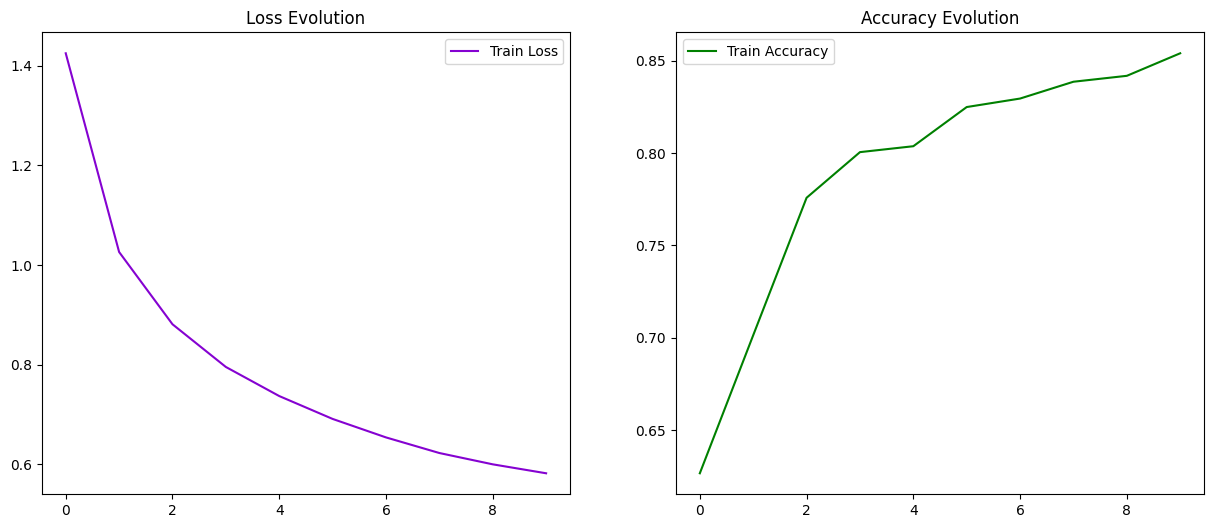

In [14]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1,2,1)
plt.plot(loss_epoch, label='Train Loss', color='#8502d1')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1,2,2)
plt.plot(acc_epoch, label='Train Accuracy', color='green')
plt.legend()
plt.title('Accuracy Evolution')


### Now, let's download a couple of real images outside the dataset and test the model.    

In [65]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

url_plane = "https://flyxo.com/_next/image/?url=https%3A%2F%2Fwebsite-cdn.flyxo.com%2Fdata%2Fwebapi%2FXO_3_D_AIRCRAFT_CHALLENGER_350_d48b816b8d_cc24a36816.jpg&w=1920&q=75"
url_truck = "https://raw.githubusercontent.com/FarzadNekouee/Keras-CIFAR10-CNN-Model/master/truck_sample.png"
resp = requests.get(url_plane)
img_test = Image.open(BytesIO(resp.content))

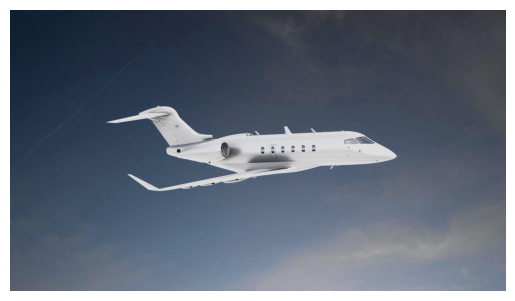

In [66]:
plt.imshow(img_test)
plt.axis("off")
plt.show()

### Using transformations to ensure 3 channel RGB format, 32x32 size

In [67]:
transforms = v2.Compose([
    v2.Resize((32,32)),
    v2.RGB(),
    v2.ToTensor(),
    v2.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])
sample = transforms(img_test)

In [81]:
model.eval()
res = model(sample.unsqueeze(0))
print(f"Predicted class = \"{classes[int(res.argmax())]}\"")
print("Nearest predictions:", [(torch.sort(x))[i] for i in range(len(res))])

Predicted class = "plane"
Nearest predictions: [tensor([[[[-9.5748e-01, -9.4161e-01, -9.2573e-01,  ..., -7.3521e-01,
           -7.3521e-01, -7.1933e-01],
          [-9.5748e-01, -9.4161e-01, -9.0985e-01,  ..., -7.1933e-01,
           -7.1933e-01, -7.1933e-01],
          [-9.5748e-01, -9.4161e-01, -9.2573e-01,  ..., -7.5108e-01,
           -7.3521e-01, -7.3521e-01],
          ...,
          [-1.9260e+00, -1.9260e+00, -1.9101e+00,  ...,  4.5555e-01,
            4.8731e-01,  7.8897e-01],
          [-1.9895e+00, -1.9260e+00, -1.8942e+00,  ...,  1.0589e+00,
            1.0747e+00,  1.1065e+00],
          [-1.5132e+00, -1.4497e+00, -1.2591e+00,  ...,  9.0010e-01,
            9.0010e-01,  9.3186e-01]],

         [[ 3.2339e-01,  3.2339e-01,  3.5567e-01,  ...,  4.5250e-01,
            4.5250e-01,  4.5250e-01],
          [ 3.3953e-01,  3.3953e-01,  3.7181e-01,  ...,  4.6864e-01,
            4.6864e-01,  5.1705e-01],
          [ 3.3953e-01,  3.3953e-01,  3.5567e-01,  ...,  4.5250e-01,
          